<a href="https://colab.research.google.com/github/Asad-Khan-AI/Advanced-Artificial-Intelligence/blob/main/Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

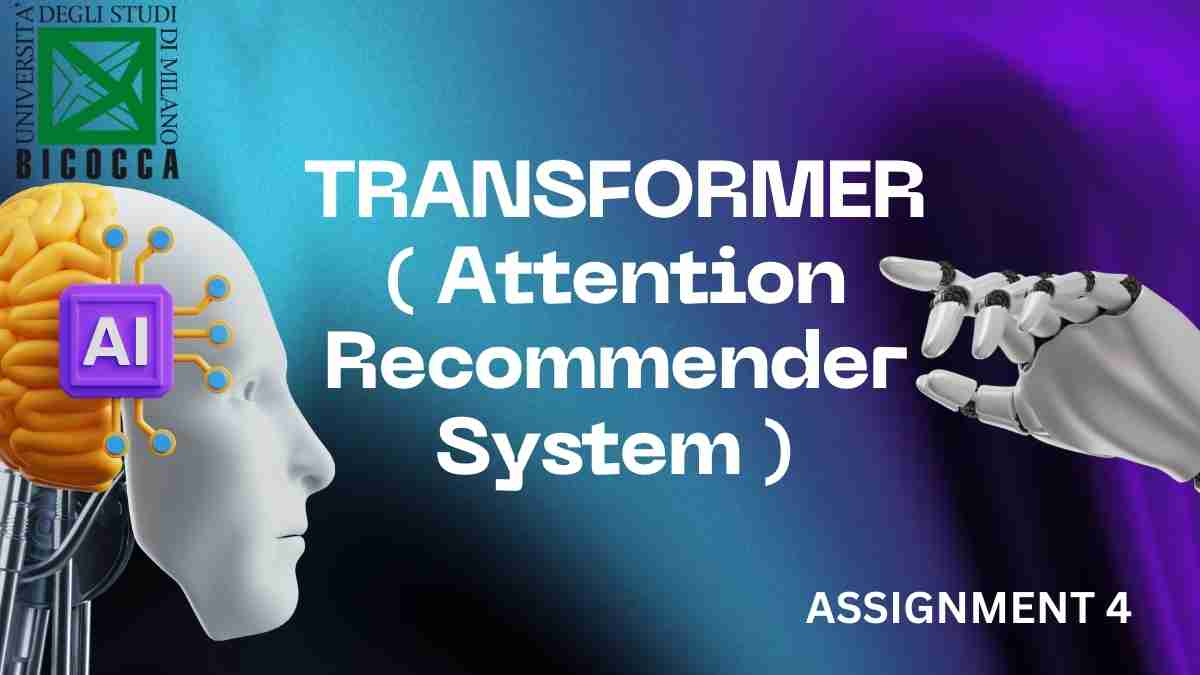

## **AI ASSIGNMENT 4:**

Transformer (Recommender System with Attention).

**The Team:**

MUHAMMAD ASAD KHAN - 910038 ( Team Lead ).

RAKESH RANKAWAT    - 910040.

AAYUSH BAJPAI      - 911190.

**INTRODUCTION:**

In this assignment, we developed a transformer model from scratch and generate personalized recommendations based on user sequences at MovieLens dataset. From dataset and model training to making the final predictions, we will go through all steps one by one.

In [ ]:
import math
import os
from tempfile import TemporaryDirectory
from typing import Tuple

import torch
from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset
from torchtext.vocab import vocab
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

from collections import Counter

from zipfile import ZipFile
from urllib.request import urlretrieve

import pandas as pd
import numpy as np

import time

# **TASK 1:**

Starting from the NeuMF model, think to a possible architecture for recommender system that leverage the attention mechanism (not necessarily a transformer-based architecture) and draw it. Explain how you plan to use attention and why it could enhanche your model performance.

&

# **TASK 2:**

Write the Data structures (Dataset and DataLoader) needed to handle you input data. If it is necessary, rewrite the preprocessing steps and also the evaluation metrics. Always use the same rating dataset from Movielens 100k.

# 1. Data Preprocessing
In this section, we'll start by loading the MovieLens dataset. We will then construct vocabularies for movie IDs and user IDs, and create sequences of user interactions. These steps are the basics for our recommendation model, converting the data into a format that our model can utilize effectively.
## 1.1 Loading Dataset
At first we will download our dataset to generate our sequences and vocabularies. Then user_id and movie_id values are processesed to fix their data types.

In [ ]:
urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens100k.zip")
ZipFile("movielens100k.zip", "r").extractall()

# Datasets
users = pd.read_csv(
    "ml-100k/u.user",
    sep="|",
    names=["user_id", "age", "sex", "occupation", "zip_code"],
    encoding='latin-1'
)

ratings = pd.read_csv(
    "ml-100k/u.data",
    sep="\t",
    names=["user_id", "movie_id", "rating", "unix_timestamp"]
)

movies = pd.read_csv(
    "ml-100k/u.item",
    sep="|",
    names=["movie_id", "title", "release_date", "video_release_date", "IMDb_URL", "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"],
    encoding='latin-1'
)

# Preventing ids to be written as integer or float data type
users["user_id"] = users["user_id"].apply(lambda x: f"user_{x}")

movies["movie_id"] = movies["movie_id"].apply(lambda x: f"movie_{x}")

ratings["movie_id"] = ratings["movie_id"].apply(lambda x: f"movie_{x}")
ratings["user_id"] = ratings["user_id"].apply(lambda x: f"user_{x}")

## 1.2 Creating Vocabulary
Now that we have our data ready, it's time to prepare our vocabularies for user IDs and movie IDs. This step will convert the unique IDs into numerical indices that our model can use. The following code snippet accomplishes this task.

In [ ]:
# Genarting a list of unique movie ids
movie_ids = movies.movie_id.unique()

# Counter is used to feed movies to movive_vocab
movie_counter = Counter(movie_ids)

# Genarting vocabulary
movie_vocab = vocab(movie_counter, specials=['<unk>'])

# For indexing input ids
movie_vocab_stoi = movie_vocab.get_stoi()

# Movie to title mapping dictionary
movie_title_dict = dict(zip(movies.movie_id, movies.title))

# Similarly generating a vocabulary for user ids
user_ids = users.user_id.unique()
user_counter = Counter(user_ids)
user_vocab = vocab(user_counter, specials=['<unk>'])
user_vocab_stoi = user_vocab.get_stoi()

## 1.3 Generating Sequences
All interactions of users are first sorted by their interaction timestamp and then divided into sub sequences to train our model.

In [ ]:
# Group ratings by user_id in order of increasing unix_timestamp.
ratings_group = ratings.sort_values(by=["unix_timestamp"]).groupby("user_id")

ratings_data = pd.DataFrame(
    data={
        "user_id": list(ratings_group.groups.keys()),
        "movie_ids": list(ratings_group.movie_id.apply(list)),
        "timestamps": list(ratings_group.unix_timestamp.apply(list)),
    }
)

# Sequence length, min history count and window slide size
sequence_length = 4
min_history = 1
step_size = 2

# Creating sequences from lists with sliding window
def create_sequences(values, window_size, step_size, min_history):
  sequences = []
  start_index = 0
  while len(values[start_index:]) > min_history:
    seq = values[start_index : start_index + window_size]
    sequences.append(seq)
    start_index += step_size
  return sequences

ratings_data.movie_ids = ratings_data.movie_ids.apply(
    lambda ids: create_sequences(ids, sequence_length, step_size, min_history)
)


del ratings_data["timestamps"]

# Sub-sequences are exploded.
# Since there might be more than one sequence for each user.
ratings_data_transformed = ratings_data[["user_id", "movie_ids"]].explode(
    "movie_ids", ignore_index=True
)

ratings_data_transformed.rename(
    columns={"movie_ids": "sequence_movie_ids"},
    inplace=True,
)

In [ ]:
ratings_data_transformed.sample(frac=1).reset_index(drop=True).head()

,user_id,sequence_movie_ids
0,user_738,"[movie_651, movie_127, movie_969, movie_265]"
1,user_340,"[movie_502, movie_504, movie_1133, movie_405]"
2,user_559,"[movie_174, movie_515, movie_180, movie_385]"
3,user_370,"[movie_257, movie_613, movie_390, movie_114]"
4,user_704,"[movie_170, movie_480, movie_210, movie_514]"


## 1.4 Train Test Split
The data is split into training and testing sets. Although considering timestamps could potentially provide a more refined split, for the sake of simplicity, we opt for a random indexing approach.

In [ ]:
# Random indexing
random_selection = np.random.rand(len(ratings_data_transformed.index)) <= 0.85

# Split train data
df_train_data = ratings_data_transformed[random_selection]
train_data_raw = df_train_data[["user_id", "sequence_movie_ids"]].values

# Split test data
df_test_data = ratings_data_transformed[~random_selection]
test_data_raw = df_test_data[["user_id", "sequence_movie_ids"]].values

DataLoader is defined to be used for training and evaluation as final pre-processing step.

In [ ]:
# Pytorch Dataset for user interactions
class MovieSeqDataset(Dataset):
    # Initialize dataset
    def __init__(self, data, movie_vocab_stoi, user_vocab_stoi):
        self.data = data

        self.movie_vocab_stoi = movie_vocab_stoi
        self.user_vocab_stoi = user_vocab_stoi


    def __len__(self):
        return len(self.data)

    # Fetch data from the dataset
    def __getitem__(self, idx):
        user, movie_sequence = self.data[idx]
        # Directly index into the vocabularies
        movie_data = [self.movie_vocab_stoi[item] for item in movie_sequence]
        user_data = self.user_vocab_stoi[user]
        return torch.tensor(movie_data), torch.tensor(user_data)


# Collate function and padding
def collate_batch(batch):
    movie_list = [item[0] for item in batch]
    user_list = [item[1] for item in batch]
    return pad_sequence(movie_list, padding_value=movie_vocab_stoi['<unk>'], batch_first=True), torch.stack(user_list)


BATCH_SIZE = 256
# Create instances of your Dataset for each set
train_dataset = MovieSeqDataset(train_data_raw, movie_vocab_stoi, user_vocab_stoi)
val_dataset = MovieSeqDataset(test_data_raw, movie_vocab_stoi, user_vocab_stoi)
# Create DataLoaders
train_iter = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=collate_batch)
val_iter = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                      shuffle=False, collate_fn=collate_batch)


# **TASK 3:**

Write the Attention-based model and train it. After finetuning, compare the performance with the best results obtained in the previous challenges.

# 2. Model Definition
In this section we will define and initialize our model. Then the model will be trained with our previously generated dataset.
## 2.1 Positional Encoder
We start by defining the positional encoder, which is crucial for sequence-based models like the Transformer. This encoder will capture the positions of movie interactions in our sequences, thus embedding the order information that the Transformer model needs.

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)

        # `div_term` is used in the calculation of the sinusoidal values.
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))

        # Initializing positional encoding matrix with zeros.
        pe = torch.zeros(max_len, 1, d_model)

        # Calculating the positional encodings.
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

## 2.2 Transformer Model
Following the definition of our positional encoder, we then establish our transformer model. This model takes both the user id and the movie id sequence as input, and it is responsible for generating the output movie predictions.

In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, ntoken: int, nuser: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        # positional encoder
        self.pos_encoder = PositionalEncoding(d_model, dropout)

        # Multihead attention mechanism.
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)

        # Embedding layers
        self.movie_embedding = nn.Embedding(ntoken, d_model)
        self.user_embedding = nn.Embedding(nuser, d_model)

        # Defining the size of the input to the model.
        self.d_model = d_model

        # Linear layer to map the output tomovie vocabulary.
        self.linear = nn.Linear(2*d_model, ntoken)

        self.init_weights()

    def init_weights(self) -> None:
        # Initializing the weights of the embedding and linear layers.
        initrange = 0.1
        self.movie_embedding.weight.data.uniform_(-initrange, initrange)
        self.user_embedding.weight.data.uniform_(-initrange, initrange)
        self.linear.bias.data.zero_()
        self.linear.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, user: Tensor, src_mask: Tensor = None) -> Tensor:
        # Embedding movie ids and userid
        movie_embed = self.movie_embedding(src) * math.sqrt(self.d_model)
        user_embed = self.user_embedding(user) * math.sqrt(self.d_model)

        # positional encoding
        movie_embed = self.pos_encoder(movie_embed)

        # generating output with final layers
        output = self.transformer_encoder(movie_embed, src_mask)

        # Expand user_embed tensor along the sequence length dimension
        user_embed = user_embed.expand(-1, output.size(1), -1)

        # Concatenate user embeddings with transformer output
        output = torch.cat((output, user_embed), dim=-1)

        output = self.linear(output)
        return output


Following the model definitions, we proceed to initialize our model using a set of arbitrarily selected hyperparameters.

In [ ]:
ntokens = len(movie_vocab)  # size of vocabulary
nusers = len(user_vocab)
emsize = 128  # embedding dimension
d_hid = 128  # dimension of the feedforward network model
nlayers = 2  # number of ``nn.TransformerEncoderLayer``
nhead = 2  # number of heads in ``nn.MultiheadAttention``
dropout = 0.2  # dropout probability

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerModel(ntokens, nusers, emsize, nhead, d_hid, nlayers, dropout).to(device)

criterion = nn.CrossEntropyLoss()
lr = 1.0  # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


# 3. Train & Evaluation
We're now ready to kick off the training process with our model, where it will learn from the dataset we've prepared. Following the training phase, we'll evaluate how well our model performs on unseen data to check its effectiveness.
## 3.1 Train Function

In [ ]:
def train(model: nn.Module, train_iter, epoch) -> None:
    # Switch to training mode
    model.train()
    total_loss = 0.
    log_interval = 200
    start_time = time.time()

    for i, (movie_data, user_data) in enumerate(train_iter):
        # Load movie sequence and user id
        movie_data, user_data = movie_data.to(device), user_data.to(device)
        user_data = user_data.reshape(-1, 1)

        # Split movie sequence to inputs and targets
        inputs, targets = movie_data[:, :-1], movie_data[:, 1:]
        targets_flat = targets.reshape(-1)

        # Predict movies
        output = model(inputs, user_data)
        output_flat = output.reshape(-1, ntokens)

        # Backpropogation process
        loss = criterion(output_flat, targets_flat)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        # Results
        if i % log_interval == 0 and i > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            ppl = math.exp(cur_loss)
            print(f'| epoch {epoch:3d} '
                  f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
            total_loss = 0
            start_time = time.time()

## 3.2 Evaluation Function

In [ ]:
def evaluate(model: nn.Module, eval_data: Tensor) -> float:
    # Switch the model to evaluation mode.
    # This is necessary for layers like dropout,
    model.eval()
    total_loss = 0.

    with torch.no_grad():
        for i, (movie_data, user_data) in enumerate(eval_data):
            # Load movie sequence and user id
            movie_data, user_data = movie_data.to(device), user_data.to(device)
            user_data = user_data.reshape(-1, 1)
            # Split movie sequence to inputs and targets
            inputs, targets = movie_data[:, :-1], movie_data[:, 1:]
            targets_flat = targets.reshape(-1)
            # Predict movies
            output = model(inputs, user_data)
            output_flat = output.reshape(-1, ntokens)
            # Calculate loss
            loss = criterion(output_flat, targets_flat)
            total_loss += loss.item()
    return total_loss / (len(eval_data) - 1)

## 3.3 Train & Evaluation Loop

In [ ]:
best_val_loss = float('inf')
epochs = 10

with TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()

        # Training
        train(model, train_iter, epoch)

        # Evaluation
        val_loss = evaluate(model, val_iter)

        # Compute the perplexity of the validation loss
        val_ppl = math.exp(val_loss)
        elapsed = time.time() - epoch_start_time

        # Results
        print('-' * 89)
        print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
            f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
        print('-' * 89)

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_params_path)

        scheduler.step()
    model.load_state_dict(torch.load(best_model_params_path)) # load best model states

-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 22.24s | valid loss  7.04 | valid ppl  1140.99
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 23.51s | valid loss  6.86 | valid ppl   950.56
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 22.85s | valid loss  6.49 | valid ppl   661.39
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   4 | time: 21.80s | valid loss  6.30 | valid ppl   544.89
--------------------------------------------------------------------------

## 3.4 Generating Popular Movie Recommendations as Baseline
In order to compare our model success a baseline recommendation method is required. One of the easiest recommendation method is popular movie recommendation which is obtained by most frequent and highly rated movies.

In [ ]:
def get_popular_movies(df_ratings):
  # Calculate the number of ratings for each movie
  rating_counts = df_ratings['movie_id'].value_counts().reset_index()
  rating_counts.columns = ['movie_id', 'rating_count']

  # Get the most frequently rated movies
  min_ratings_threshold = rating_counts['rating_count'].quantile(0.95)

  # Filter movies based on the minimum number of ratings
  popular_movies = ratings.merge(rating_counts, on='movie_id')
  popular_movies = popular_movies[popular_movies['rating_count'] >= min_ratings_threshold]


  # Calculate the average rating for each movie
  average_ratings = popular_movies.groupby('movie_id')['rating'].mean().reset_index()
  # Get the top 10 rated movies
  top_10_movies = list(average_ratings.sort_values('rating', ascending=False).head(10).movie_id.values)
  return top_10_movies

In [ ]:
top_10_movies = get_popular_movies(ratings)
[movie_title_dict[movie] for movie in top_10_movies]

["Schindler's List (1993)",
 'Casablanca (1942)',
 'Shawshank Redemption, The (1994)',
 'Usual Suspects, The (1995)',
 'Star Wars (1977)',
 "One Flew Over the Cuckoo's Nest (1975)",
 'Silence of the Lambs, The (1991)',
 'Godfather, The (1972)',
 'Raiders of the Lost Ark (1981)',
 'Titanic (1997)']

## 3.5 Recommendations Result Comparison
Like the evaluation function we will iterate our validation dataset and store recommendation results in lists to compare them with normalized discounted gain(NDCG) metric.

In [ ]:
# Movie id decoder
movie_vocab_itos = movie_vocab.get_itos()

# A placeholders to store results of recommendations
transformer_reco_results = list()
popular_reco_results = list()

# Get top 10 movies
k = 10
# Iterate over the validation data
for i, (movie_data, user_data) in enumerate(val_iter):
    # Feed the input and get the outputs
    movie_data, user_data = movie_data.to(device), user_data.to(device)
    user_data = user_data.reshape(-1, 1)
    inputs, targets = movie_data[:, :-1], movie_data[:, 1:]
    output = model(inputs, user_data)
    output_flat = output.reshape(-1, ntokens)
    targets_flat = targets.reshape(-1)

    # Reshape the output_flat to get top predictions
    outputs = output_flat.reshape(output_flat.shape[0] // inputs.shape[1],
                                  inputs.shape[1],
                                  output_flat.shape[1])[: , -1, :]
    # k + len(inputs) = 13 movies obtained
    # In order to prevent to recommend already watched movies
    values, indices = outputs.topk(k + inputs.shape[1], dim=-1)

    for sub_sequence, sub_indice_org in zip(movie_data, indices):
        sub_indice_org = sub_indice_org.cpu().detach().numpy()
        sub_sequence = sub_sequence.cpu().detach().numpy()

        # Generate mask array to eliminate already watched movies
        mask = np.isin(sub_indice_org, sub_sequence[:-1], invert=True)

        # After masking get top k movies
        sub_indice = sub_indice_org[mask][:k]

        # Generate results array
        transformer_reco_result = np.isin(sub_indice, sub_sequence[-1]).astype(int)

        # Decode movie to search in popular movies
        target_movie_decoded = movie_vocab_itos[sub_sequence[-1]]
        popular_reco_result = np.isin(top_10_movies, target_movie_decoded).astype(int)

        transformer_reco_results.append(transformer_reco_result)
        popular_reco_results.append(popular_reco_result)

After generating result for each recommendation now time to compare baseline method vs transformer model.

In [ ]:
from sklearn.metrics import ndcg_score

# Since we have already sorted our recommendations
# An array that represent our recommendation scores is used.
representative_array = [[i for i in range(k, 0, -1)]] * len(transformer_reco_results)

for k in [3, 5, 10]:
  transformer_result = ndcg_score(transformer_reco_results,
                                  representative_array, k=k)
  popular_result = ndcg_score(popular_reco_results,
                              representative_array, k=k)

  print(f"Transformer NDCG result at top {k}: {round(transformer_result, 4)}")
  print(f"Popular recommendation NDCG result at top {k}: {round(popular_result, 4)}\n\n")


Transformer NDCG result at top 3: 0.0487
Popular recommendation NDCG result at top 3: 0.0067


Transformer NDCG result at top 5: 0.062
Popular recommendation NDCG result at top 5: 0.0102


Transformer NDCG result at top 10: 0.0839
Popular recommendation NDCG result at top 10: 0.015




**ATTENTION MODEL PERFORMANCE:**

Here we have seen our model results are approximately 10 times better than popular movie recommendation at NDCG metric. A function to generate recommendation for single data is given below.

In [ ]:
def generate_recommendation(user_id, movie_sequence, k=10):
    model.eval()
    input_sequence = movie_sequence[:-1]
    # Tokenize and numerically encode the user id and movie sequence
    user_tensor = torch.tensor(user_vocab_stoi[user_id])
    movie_tensor = torch.tensor([[movie_vocab_stoi[movie_id]] for movie_id in input_sequence])
    # Shape: [1, 1]
    user_tensor = user_tensor.unsqueeze(0).to(device)
    user_tensor = user_tensor.view(user_tensor.shape[0], 1)

    # Shape: [1, seq_length]
    movie_tensor = movie_tensor.unsqueeze(0).to(device)[0]
    movie_tensor = movie_tensor.view(1, movie_tensor.shape[0])

    # Pass the tensors through the model
    with torch.no_grad():
        predictions = model(movie_tensor, user_tensor)

    # The output is a probability distribution over the next movie.
    # Topk to get most probable movies
    values, indices = predictions.topk(k + len(input_sequence), dim=-1)
    # Eliminate already watched movies
    indices = [indice for indice in indices[-1, :][0] if indice not in movie_tensor][:k]
    predicted_movies = [movie_title_dict[movie_vocab.get_itos()[movie]] for movie in indices]
    return predicted_movies

In [ ]:
row_iter = test_data_raw[7463]
print("Input Sequence:")
print("-" + "\n-".join([movie_title_dict[ea_movie] for ea_movie in row_iter[1][:-1]]))
recos = '\n-'.join(generate_recommendation(row_iter[0],row_iter[1]))

print(f"Recomendations:\n-{recos}")

Input Sequence:
-Get Shorty (1995)
-Jurassic Park (1993)
-Picture Perfect (1997)
Recomendations:
-Pulp Fiction (1994)
-Ed Wood (1994)
-Blues Brothers, The (1980)
-Desperado (1995)
-When Harry Met Sally... (1989)
-Real Genius (1985)
-Field of Dreams (1989)
-Blade Runner (1982)
-Heathers (1989)
-Princess Bride, The (1987)



**Comparision with Previous Assignments:**


**Assignment 2: LIME and SHAP**

Training Process: The model was trained with a cross-entropy loss over 50 epochs.

Evaluation: Achieved a Test MSE of 1.1630, indicating reasonable predictive performance.

LIME Explanation: Provided insights into individual predictions, highlighting local model behavior.

**Assignment 3: Random Walk**

Training Process: Executed over 10 epochs, optimizing a loss function indicative of the Random Walk approach.

Recommendations: Generated recommendations based on matrix factorization results for specific movies.

Strengths: Effective in graph-based scenarios, where item relationships are modeled as nodes.

**Assignment 4: Attention-based Transformer**

Training Process: Trained over 10 epochs with a Transformer architecture, optimizing for validation loss reduction.

Evaluation: Achieved decreasing validation loss and perplexity (a measure of model performance).

Recommendations: Produced recommendations based on sequential dependencies learned by the Transformer model.

Strengths: Captures complex dependencies and sequences, suitable for dynamic recommendation tasks.


**Comparative Evaluation:**

1. Performance Metrics:

LIME/SHAP (Test MSE: 1.1630): Provides a direct measure of prediction accuracy, which is reasonable but lacks context on scalability and generalizability.

Random Walk: Optimal for graph-based scenarios, but its direct comparison in terms of MSE or accuracy is not provided.

**Attention-based Transformer:** Achieved decreasing validation loss (6.14 to 6.13) over epochs, indicating improving model convergence and potential for higher predictive accuracy in sequential recommendation tasks.

2. Model Complexity and Interpretability:

LIME/SHAP: Offers transparent insights into individual predictions, aiding in model interpretability but may not directly enhance predictive performance.

Random Walk: Simpler to implement and understand for graph-based recommendation scenarios but might not capture intricate dependencies as well as advanced models like Transformers.

**Attention-based Transformer:** Captures long-range dependencies and dynamic user behavior patterns, potentially leading to superior recommendation quality in dynamic environments.

3. Application Suitability:

LIME/SHAP: Best for applications where transparency and interpretability are crucial (e.g., healthcare, finance).

Random Walk: Suitable for static graph-based recommendation scenarios (e.g., social networks, citation networks).

**Attention-based Transformer:** Ideal for dynamic recommendation tasks where user preferences evolve over time (e.g., e-commerce, personalized content).

# Conclusion and Camparision:
In this assignment, we have made an attempt to use the Transformer model, known for its effectiveness in NLP, to create a movie attention based recommendation system. We have gone through from data preprocessing to prediction step using the MovieLens dataset 100K.

**ATTENTION MODEL PERFORMANCE:**

Here we have seen our model results are approximately 10 times better than popular movie recommendation at NDCG metric.While this is a starting point, it hopefully sheds some light on how Transformer can be used in different contexts, such as recommendation systems.

While each technique—LIME/SHAP, Random Walk, and Attention-based Transformer—has its strengths and applications, the Attention-based Transformer appears to offer the most promising results for recommendation systems, particularly in dynamic and sequential contexts. Its ability to model complex dependencies and adapt to evolving user preferences can lead to higher-quality recommendations compared to simpler methods like Random Walk and more interpretative techniques like LIME/SHAP, which focus on explanation rather than direct enhancement of predictive performance.

Therefore, based on the provided results and considerations, the Attention-based Transformer recommendation system seems to offer the best potential for improving recommendation accuracy and adapting to dynamic user behaviors. However, the final determination also depends on specific use case requirements, model complexity, interpretability, and performance metrics.